### Evangelos Gougoulis Dimitriadis Bag of Words Image Retrieval using SIFT keypoint finder and descriptor. 

In [6]:
# install the library h5py (needed to load and read the ground truth relevance feedback file)
!pip3 install h5py

In [10]:
#install this library to run SIFT implementation
!pip install opencv-contrib-python

In [12]:
import json
import numpy as np
import h5py
import matplotlib.pyplot as plt

## Load the query and map images
with open("data02/map.json","r") as f:
    m_idx = json.load(f)
    m_imgs = np.array(m_idx["im_paths"])
    m_poses=np.array(m_idx["poses"])
with open("data02/query.json","r") as f:
    q_idx=json.load(f)
    q_imgs=np.array(q_idx["im_paths"])
    q_poses=np.array(q_idx["poses"])

In [13]:
# loading the relevance judgements
with h5py.File("data02/gt.h5","r") as f:
    fovs = f["fov"][:]
    sim = f["sim"][:].astype(np.uint8)

## SIFT IMPLEMENTATION

In [14]:
import os
import cv2
import time
import sklearn
from sklearn.cluster import KMeans
from scipy.spatial import distance

t = time.process_time()

## extract the descriptors from all images. ##
sift = cv2.xfeatures2d.SIFT_create()

# Initialize the data structure that will contain all the descriptors
descriptors = None
# Loop over map images
for img_name in m_imgs:

    img = cv2.imread(os.path.join('data02/', img_name))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (kps, descriptors_img) = sift.detectAndCompute(gray, None)

    if descriptors is None:
        descriptors = descriptors_img
    else:
        descriptors = np.vstack( (descriptors, descriptors_img))
               
print(descriptors.shape)

## CLUSTERING ##

K = 100  # number of clusters (equivalent to the number of words) we want to estimate
kmeans = KMeans(n_clusters=K, random_state=0, n_init=1)
clusters = kmeans.fit(descriptors)  # we use the descriptors extracted from the map (training) images before
centroids = clusters.cluster_centers_

print("Shape of the centroids matrix: ", centroids.shape)
print("We computed ", centroids.shape[0], "centroids of lengh ", centroids.shape[1], " (the same of the descriptor)")
# Rememeber: the centroids can be considered as the words that compose our documents 
# -> in this case the basic components of the images


## BAG OF WORDS VECTOR COMPUTAION ##

def bag_of_words(centroids, img_descriptors):
    n_centroids = centroids.shape[0]  # number of centroids found with the KMeans clustering #100
    n_descriptors = img_descriptors.shape[0]  # number of descriptors extracted from the image #200
    
    # initialization of the bag of words (BoW) vector
    # Note that the BoW vector has length equal to the number of cluster centroids
    # The cluster centroids are indeed our visual words, and the BoW will be the histogram of these words found in the given image
    bow_vector = np.zeros(n_centroids)  
    
    for i in range(n_descriptors):
        for j in range(n_centroids):
            if img_descriptors[i][j]==True: #if the feature is in the image (true in img_descriptor)
                bow_vector[j]+=1            #bow_vector.shape => 100 (for each image)
    return bow_vector


## BAG OF WORDS REPRESENTATION OF MAP IMAGES ## 

bow_map_images = None
# loop over the images in the map set
for img_name in m_imgs:
    # load image
    img = cv2.imread(os.path.join('data02/', img_name))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (kps, img_descriptors) = sift.detectAndCompute(gray, None)

    # compute BoW representation of the image (using the basic 'words', i.e. centroinds, computed earlier)
    bow = bag_of_words(centroids, img_descriptors)
    # add the computed BoW vector to the set of map representations
    if bow_map_images is None:
        bow_map_images = bow
    else:
        bow_map_images = np.vstack( (bow_map_images, bow))
        
        
## RETRIEVE IMAGES ##

def retrieve_images(map_bow_vectors, query_bow):
    n_map_bow_vectors = map_bow_vectors.shape[0]
    bow_distances = np.zeros(n_map_bow_vectors)
    most_similar = None  
    
    for i in range(n_map_bow_vectors):
        for j in range(len(query_bow)):
            
            #bow_distances[i] += distance.euclidean(map_bow_vectors[i][j], query_bow[j])        
            #bow_distances[i] +=distance.minkowski(map_bow_vectors[i][j], query_bow[j])
            bow_distances[i] += distance.cosine(map_bow_vectors[i][j], query_bow[j])
            #bow_distances[i] += distance.cityblock(map_bow_vectors[i][j], query_bow[j]) #manhattan
              
    most_similar=np.argsort(bow_distances)
    most_similar=most_similar[:10]
        
    return most_similar

# Retrieve the most similar images to query image 87 (index 87-1=86)
query_idx = 86
img = cv2.imread(os.path.join("data02/" + q_imgs[query_idx]))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
(kps, query_img_descriptors) = sift.detectAndCompute(gray, None)

bow = bag_of_words(centroids, query_img_descriptors)

# Retrieve the indices of the top-10 similar images from the map
retrieved_images = retrieve_images(bow_map_images, bow)

print('Indices of similar images retrieved: ', retrieved_images)
# Indices of the relevant map images for the query: we have the relevance judgements (Ground truth)
relevant_images = np.where(sim[86, :] == 1)[0]
print('Indices of relevant images (given in the GT relevance judgements): ', relevant_images)


elapsed_time = time.process_time() - t
print(elapsed_time)

(566753, 128)
Shape of the centroids matrix:  (100, 128)
We computed  100 centroids of lengh  128  (the same of the descriptor)


C:\Users\gougo\anaconda3\lib\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Indices of similar images retrieved:  [ 0 72 71 70 69 68 67 66 65 64]
Indices of relevant images (given in the GT relevance judgements):  [59 60 61 62 63 65 66 67]
918.3125


## Evaluation of performance

In [16]:
def precision_at_k(relevant, retrieved, k):
    if len(retrieved) == 0:
        print("Retrieved list is empty")
        return 0
    counter = 0
    for retr in retrieved:
        if retr in relevant:
            counter +=1

    if k > len(retrieved):
        return counter / len(retrieved)
    else:
        return counter / k
    
print('retrieved',retrieved_images)
print('relevant',relevant_images)

print('P@5: ', precision_at_k(relevant_images, retrieved_images , 5))
print('P@10: ', precision_at_k(relevant_images, retrieved_images , 10))

retrieved [ 0 72 71 70 69 68 67 66 65 64]
relevant [59 60 61 62 63 65 66 67]
P@5:  0.6
P@10:  0.3


In [15]:
## Visualization of queued and retrieved images

(-0.5, 751.5, 479.5, -0.5)

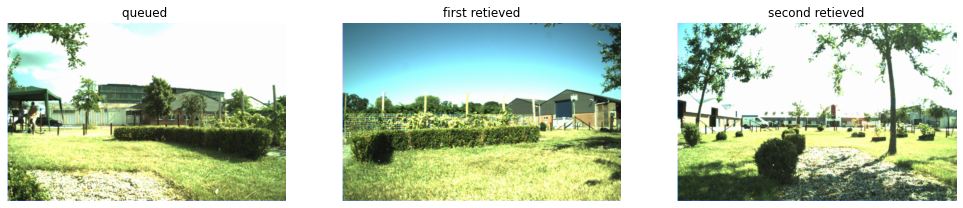

In [17]:
plt.figure(figsize=(17,10))

plt.subplot(1,3,1)
plt.title('queued ')
plt.imshow(plt.imread("data02/" + q_imgs[query_idx]))
plt.axis("off")

plt.subplot(1,3,2)
plt.title('first retieved')
plt.imshow(plt.imread("data02/" + m_imgs[retrieved_images[0]]))
plt.axis("off")

plt.subplot(1,3,3)
plt.title('second retieved')
plt.imshow(plt.imread("data02/" + m_imgs[retrieved_images[1]]))
plt.axis("off")